In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util.plot import plot_cdf,plot_lines,plot_box_by_config
from util.consts import balance_size_bins, balance_size_bins_label
from util.plot import color_list
import json
import os
from collections import defaultdict

flowsim-sldn: (1, 85584)
final_10-sldn: (1, 85584)


/data1/lichenni/projects/per-flow-sim/util/plot.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


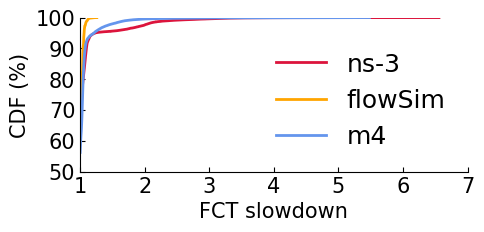

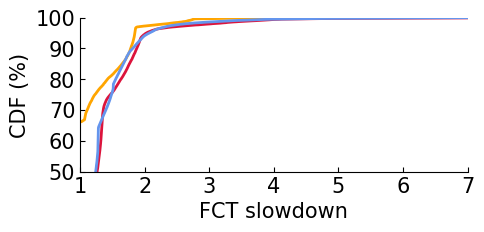

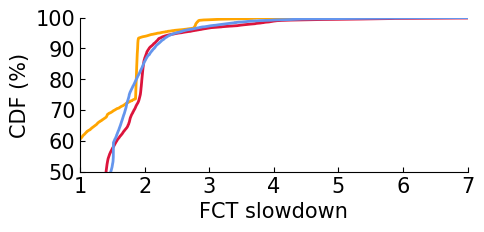

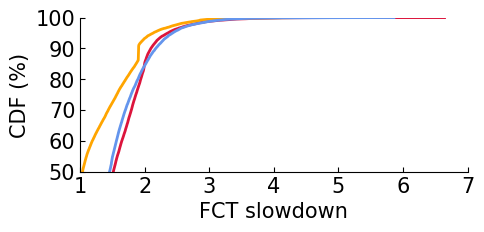

In [2]:
size_bins = [0, 1 * 1024, 200 * 1024, 1024 * 1024, np.inf]  # Sizes in bytes
size_bin_labels = ['<=1KB', '1KB-200KB','200KB-1MB', '1MB']
legend_list=['ns-3','flowSim','m4']
model_instance_list=['flowsim',"final_10"]
n_methods = len(legend_list)
fig_index=0
for scenario_idx in [0]:
    empirical_str = f"_large{scenario_idx}"

    sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_7/data/{scenario_idx}/ns3/fsize.npy')

    error_list=[]
    error_size_list=[]
    for model_idx,model_instance in enumerate(model_instance_list):
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0]
        actual_sldns = sldn[:,:, 1]
        print(f"{model_instance}-sldn: {predicted_sldns.shape}")
        
        predicted_sldns[predicted_sldns<1]=1
        actual_sldns[actual_sldns<1]=1
        if model_idx==0:
            error_list.extend([actual_sldns,predicted_sldns])
            error_size_list.extend([sizes,sizes])
        else:
            error_list.append(predicted_sldns)
            error_size_list.append(sizes)

    # Initialize a dictionary to store errors per size bucket for each model instance
    error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

    # Process the data for each model instance
    for mi in range(n_methods):
        legend = legend_list[mi]
        errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
        sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

        # Flatten the arrays
        errors_flat = errors.flatten()
        sizes_flat = sizes.flatten()

        # Assign flows to size buckets
        size_indices = np.digitize(sizes_flat, size_bins)

        # Collect errors for each size bucket
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = errors_flat[bin_mask]
            error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

    # Plot the CDF of errors for each size bucket
    for idx, size_bin_label in enumerate(size_bin_labels):
        plot_data=[]
        for mi, legend in enumerate(legend_list):
            bin_errors = error_bins[legend][size_bin_label]
            plot_data.append(bin_errors)
        plot_cdf(plot_data,f'./figs/eva_large_scale_cdf_{idx}.pdf',legend_list if idx==0 else [],'FCT slowdown',legend_font=18,group_size=3,loc=4,rotate_xaxis=False,ylim_low=50,log_switch=False,xlim=7,xlim_bottom=1, fig_idx=fig_index)
        fig_index+=1

-----------------
flowsim_large0-sldn: (85584,)
p99 slowdown: 2.70716249702616, 3.3371159918619004
final_10_large0-sldn: (85584,)
p99 slowdown: 3.068893063068388, 3.3371159918619004
mean error:[19.796066156243874, 7.8684682423973324]
p99 error: [18.87718306  8.03756685]
-----------------
flowsim_large1-sldn: (573200,)
p99 slowdown: 1.894515957568375, 2.726311837855774
final_10_large1-sldn: (573200,)
p99 slowdown: 2.3125627064704894, 2.726311837855774
mean error:[11.783684584416266, 7.3040776669639005]
p99 error: [30.50993172 15.17614844]
-----------------
flowsim_large2-sldn: (92278,)
p99 slowdown: 2.258125336602001, 3.245190878982736
final_10_large2-sldn: (92278,)
p99 slowdown: 2.701640210151671, 3.245190878982736
mean error:[13.06790256885921, 6.142199430141441]
p99 error: [30.41625529 16.74942058]


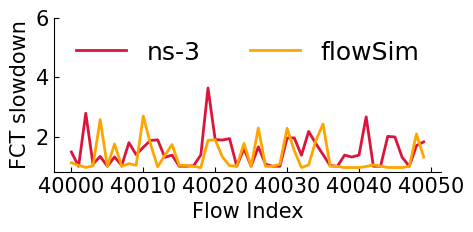

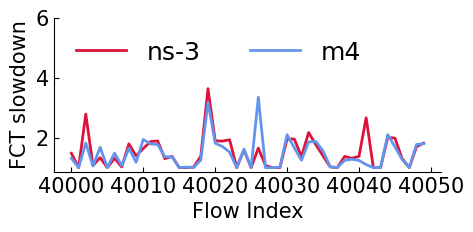

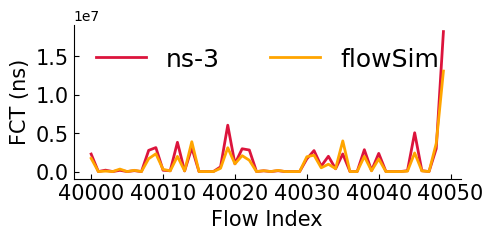

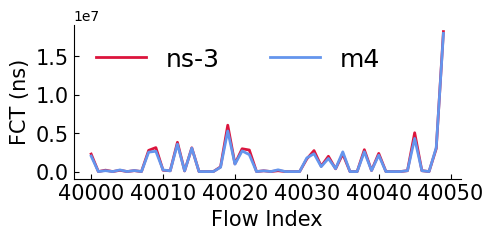

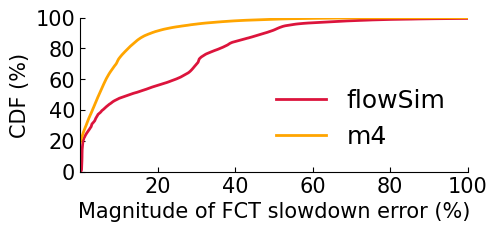

In [12]:
empirical_str = ""

legend_list=['flowSim','m4']

for scenario_idx,scenario_str in enumerate(["_large0","_large1","_large2"]):
    model_instance_list=[f'flowsim{scenario_str}',f"final_10{scenario_str}"]
                        
    error_list=[]
    error_list_p99=[]
    sldn_list=[]
    fct_list=[]
    print(f"-----------------")
    for model_instance in model_instance_list:
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0].squeeze()
        actual_sldns = sldn[:,:, 1].squeeze()
        print(f"{model_instance}-sldn: {predicted_sldns.shape}")
        
        fct=data_m4['fct']
        predicted_fcts = fct[:, :, 0].squeeze()
        actual_fcts = fct[:,:, 1].squeeze()
        
        predicted_sldns[predicted_sldns==0]=1
        actual_sldns[actual_sldns==0]=1
        # calculate the relative error
        relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
        sldn_list.append([actual_sldns,predicted_sldns])
        fct_list.append([actual_fcts,predicted_fcts])
        error_list.append(relative_error_sldn)
        
        sldn_p99_est=np.percentile(predicted_sldns,99)
        sldn_p99_act=np.percentile(actual_sldns,99)
        print(f"p99 slowdown: {sldn_p99_est}, {sldn_p99_act}")
        error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
    error_list=np.array(error_list)
    error_list_p99=np.array(error_list_p99)
    sldn_list=np.array(sldn_list)
    fct_list=np.array(fct_list)
    print(f"mean error:{[np.mean(x) for x in error_list]}")
    print(f"p99 error: {error_list_p99}")
    
    if scenario_idx==0:  
        fig_idx=0
        data_x=np.arange(40000, 40050)
        linelabels = [["ns-3","flowSim"],["ns-3","m4"]]
        format_idx=[[0,1],[0,2]]
        for i, (actual, predicted) in enumerate(sldn_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                f'./figs/eva_large_scale_line_sldn_{i}.pdf',
                linelabels[i],
                x_label="Flow Index",
                y_label="FCT slowdown",
                title=None,
                ylim=6,
                format_idx=format_idx[i],
                legend_cols=2,
                legend_font=18,
                fig_idx=fig_idx,
            )
            fig_idx+=1

        for i, (actual, predicted) in enumerate(fct_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                f'./figs/eva_large_scale_line_fct_{i}.pdf',
                linelabels[i],
                x_label="Flow Index",
                y_label="FCT (ns)",
                title=None,
                # log_switch=True,
                # ylim=6,
                format_idx=format_idx[i],
                legend_cols=2,
                legend_font=18,
                fig_idx=fig_idx,
            )
            fig_idx+=1
            
        plot_cdf(
            error_list,
            f'./figs/eva_large_scale_cdf.pdf',
            legend_list,
            x_label="Magnitude of FCT slowdown error (%)",
            log_switch=False,
            rotate_xaxis=False,
            xlim=100,
            xlim_bottom=0.01,
            fontsize=15,
            legend_font=18,
            loc=4,
            enable_abs=True,
            group_size=5,
            fig_idx=fig_idx
        )

flowsim-sldn: (100, 80000)
final_10-sldn: (100, 80000)
p99 error:[51.318473578274116, 30.861910103016758]
mean error:[19.992697597582136, 11.847883297628956]
median error:[18.238018190723377, 10.19377302745006]
p99 error:[23.874223952716665, 8.662522686805126]


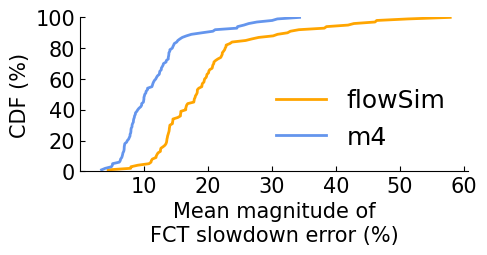

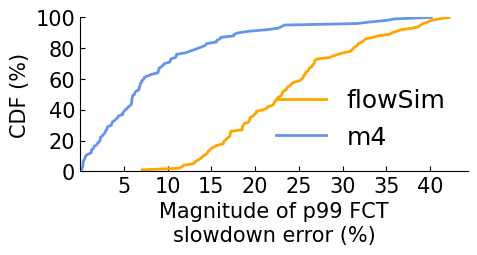

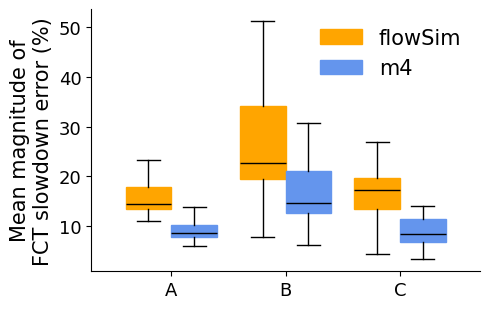

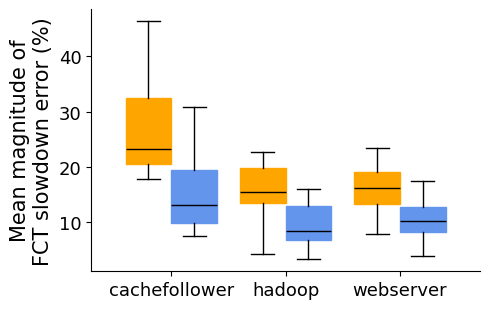

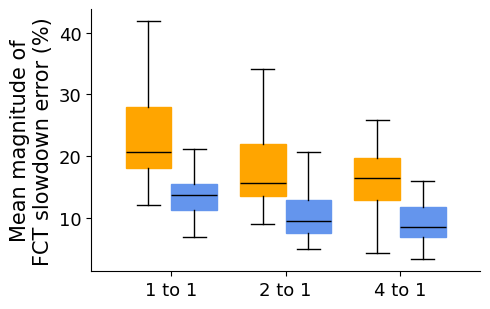

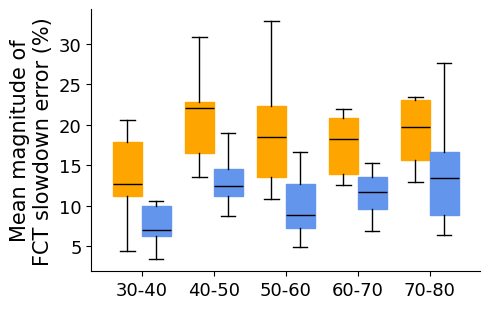

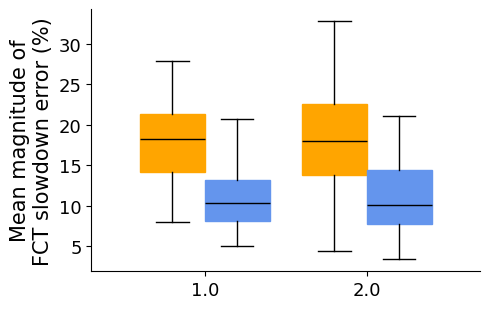

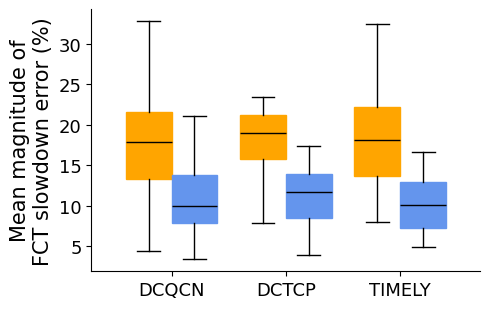

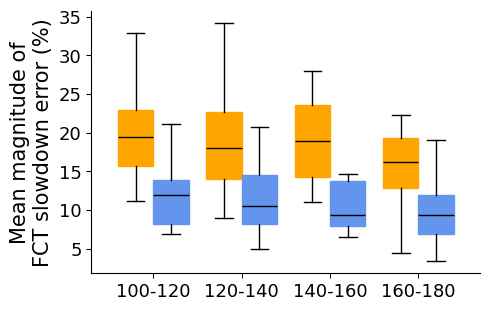

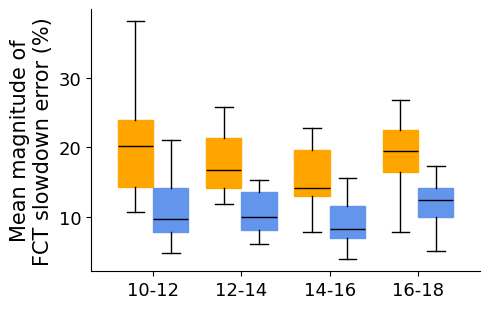

In [13]:
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m4']
model_instance_list=['flowsim','final_10']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    # if spatial!="cluster_c_4_16":
    # if size_dist!='webserver-all':
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_cdf_mean.pdf",
    legend_list,
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
)
fig_idx+=1

plot_cdf(
    error_list_p99,
    f"./figs/eva_cdf_p99.pdf",
    legend_list,
    x_label="Magnitude of p99 FCT\nslowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
)
fig_idx+=1

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3, 0.4,0.5, 0.6, 0.7, 0.8]
labels = ['30-40', '40-50', '50-60', '60-70', '70-80']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bfsz_values=bfsz_values*10
bins = [100,120,140,160,180]
labels = ['100-120', '120-140', '140-160', '160-180']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [10000,12000,14000,16000,18000]
labels = ['10-12', '12-14', '14-16', '16-18']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)

# Generate plots for each configuration attribute
config_attributes = ["Traffic matrix", "Flow size distribution", "Oversubscription", "Max load (%)", "Burstiness (log-normal's $\sigma$)", "Congestion control algorithm", "Buffer size (KB)", "Init. window size (KB)"]
error_list=error_list.T
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list, legend_list if i==0 else None,n_methods=len(legend_list),config_list=config_list, config_index=i, config_name=config_name,fig_idx=fig_idx,loc=1,file_name=f"figs/eva_box_{i}.pdf",y_label="Mean magnitude of\nFCT slowdown error (%)")
    fig_idx+=1

flowsim-sldn: (100, 80000)
final_10-sldn: (100, 80000)
final_nosize_11-sldn: (100, 80000)
final_noqueue_9-sldn: (100, 80000)
p99 error:[51.318473578274116, 30.861910103016758, 35.164010448076546, 44.356283291556814]
mean error:[19.992697597582136, 11.847883297628956, 14.000576128718707, 15.259909862755793]
median error:[18.238018190723377, 10.19377302745006, 12.53077051800835, 13.09215816283924]
p99 error:[23.874223952716665, 8.662522686805126, 13.429644007688143, 19.28207145077418]


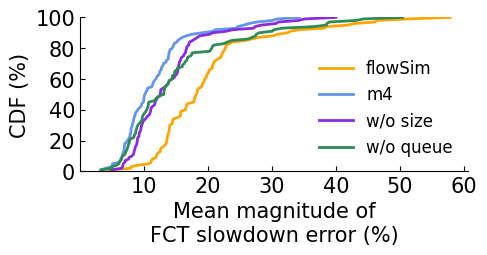

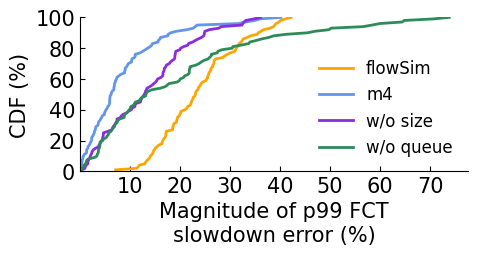

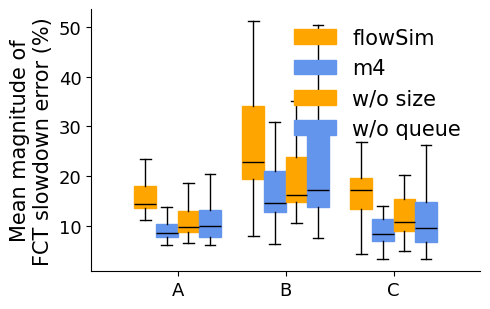

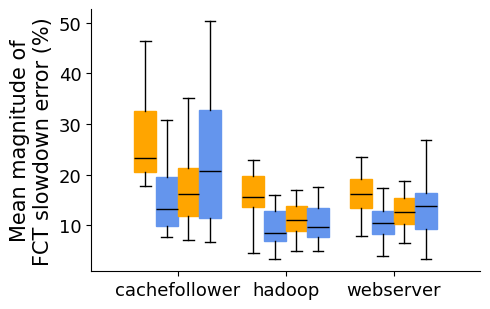

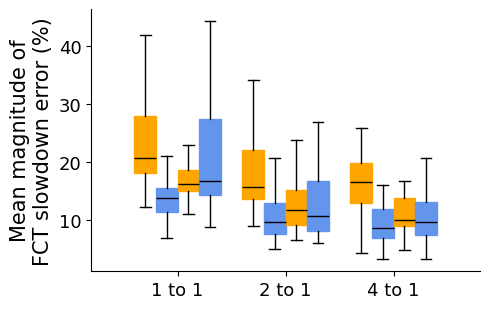

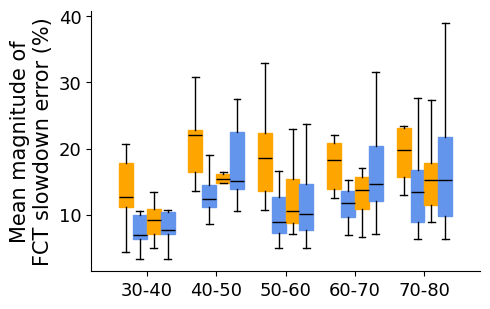

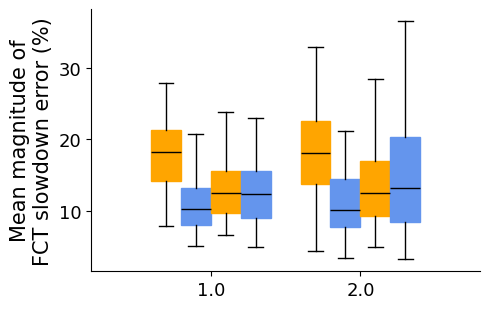

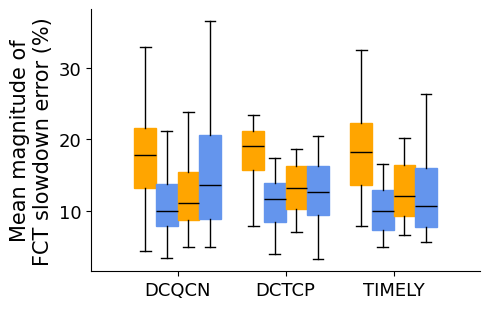

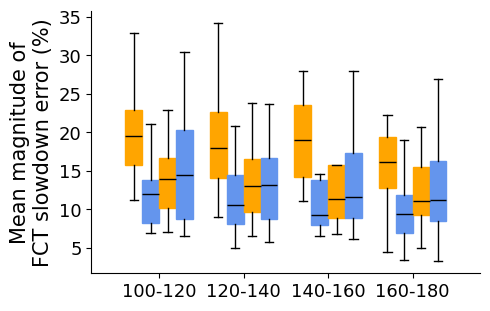

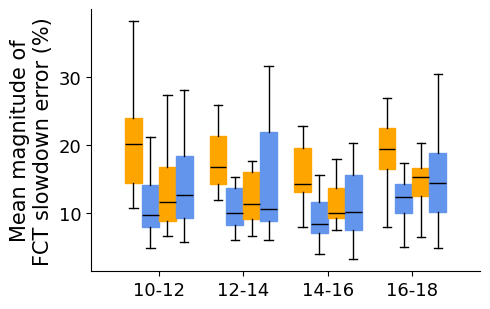

In [15]:
n_scenario=100
empirical_str = "eval_test"
# legend_list=['flowSim','m4','m4_nosupervision','m4_nosize','m4_noqueue']
# model_instance_list=['flowsim','m4_10','final_nosupervision_12','final_nosize_11','final_noqueue_9']
legend_list=['flowSim','m4','w/o size','w/o queue']
model_instance_list=['flowsim','final_10','final_nosize_11','final_noqueue_9']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_ablation_supervision_mean.pdf",
    legend_list,
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen"],
    fig_idx=fig_idx,
)
fig_idx+=1

plot_cdf(
    error_list_p99,
    f"./figs/eva_ablation_supervision_p99.pdf",
    legend_list,
    x_label="Magnitude of p99 FCT\nslowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen"],
    fig_idx=fig_idx,
)
fig_idx+=1

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3, 0.4,0.5, 0.6, 0.7, 0.8]
labels = ['30-40', '40-50', '50-60', '60-70', '70-80']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bfsz_values=bfsz_values*10
bins = [100,120,140,160,180]
labels = ['100-120', '120-140', '140-160', '160-180']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [10000,12000,14000,16000,18000]
labels = ['10-12', '12-14', '14-16', '16-18']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)

# Generate plots for each configuration attribute
config_attributes = ["Traffic matrix", "Flow size distribution", "Oversubscription", "Max load (%)", "Burstiness (log-normal's $\sigma$)", "Congestion control algorithm", "Buffer size (KB)", "Init. window size (KB)"]
error_list=error_list.T
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list, legend_list if i==0 else None,n_methods=len(legend_list),config_list=config_list, config_index=i, config_name=config_name,fig_idx=fig_idx,loc=1,file_name=None,y_label="Mean magnitude of\nFCT slowdown error (%)")
    fig_idx+=1

In [6]:
# Define constants
n_scenario = 100
empirical_str = "eval_test"
legend_list = ["flowSim", "m4"]
model_instance_list = ["flowsim", "final_10"]

n_methods = len(legend_list)

# Load configurations
config_file = f"/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json"
configs = json.load(open(config_file))

# Find available scenarios
index_list_ori = []
for i in range(n_scenario):
    if os.path.exists(
        f"/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy"
    ):
        index_list_ori.append(i)

# Prepare config_list
index_list = []
config_list = []
for idx, i in enumerate(index_list_ori):
    config = configs[i]
    max_load = float(config["max_load"])
    cc = config["cc"]  # Congestion control algorithm
    config_list.append([max_load, cc])  # Include max_load and cc
    index_list.append(idx)
config_list = np.array(config_list)

# Define flow size buckets and labels
size_bins = [0, 1 * 1000, 10 * 1000, 50 * 1000, np.inf]  # Sizes in bytes
size_bin_labels = ["<=1KB", "1KB-10KB", "10KB-50KB", ">50KB"]

# Define max load groups
max_load_bins = [0, 0.50, np.inf]
max_load_labels = ["<50%", ">50%"]

# Initialize error storage
error_by_model = {
    model: {
        cc: {load: {label: [] for label in size_bin_labels} for load in max_load_labels}
        for cc in set(config_list[:, 1])
    }
    for model in legend_list
}

# Process scenarios
for idx, scenario_idx in enumerate(index_list):
    # Load flow sizes
    sizes = np.load(
        f"/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{scenario_idx}/ns3/fsize.npy"
    )

    # Flatten sizes to match dimensions with relative errors
    sizes = sizes.flatten()

    # Group flows into size buckets
    size_indices = np.digitize(sizes, size_bins)

    # Get max load and CC group for the scenario
    max_load = config_list[idx, 0]
    cc = config_list[idx, 1]
    load_group = max_load_labels[np.digitize(max_load, max_load_bins, right=False) - 1]

    # Process each model instance
    for model_idx, model_instance in enumerate(model_instance_list):
        model_name = legend_list[model_idx]
        data = np.load(f"./res/{model_instance}{empirical_str}.npz")
        sldn = data["fct"]
        predicted_sldns = sldn[scenario_idx, : len(sizes), 0]
        actual_sldns = sldn[scenario_idx, : len(sizes), 1]

        # Calculate relative errors
        relative_errors = np.abs(actual_sldns - predicted_sldns) / actual_sldns * 100

        # Flatten relative_errors to match sizes
        relative_errors = relative_errors.flatten()

        # Group errors into buckets
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = relative_errors[bin_mask]
            error_by_model[model_name][cc][load_group][size_bin_labels[b - 1]].extend(
                bin_errors
            )

# Calculate mean error for each model, CC, max load group, and size bucket
mean_error_results = {
    model: {
        cc: {
            load: {
                bucket: np.mean(errors) if errors else 0
                for bucket, errors in group.items()
            }
            for load, group in load_group_dict.items()
        }
        for cc, load_group_dict in cc_group_dict.items()
    }
    for model, cc_group_dict in error_by_model.items()
}

num_results = {
    model: {
        cc: {
            load: {bucket: len(errors) for bucket, errors in group.items()}
            for load, group in load_group_dict.items()
        }
        for cc, load_group_dict in cc_group_dict.items()
    }
    for model, cc_group_dict in error_by_model.items()
}

# Print results
print("Mean Error by Model, CC, Load Group, and Flow Size Bucket:")
for model, cc_group_dict in mean_error_results.items():
    print(f"\nModel: {model}")
    for cc, load_group_dict in cc_group_dict.items():
        print(f"  Congestion Control: {cc}")
        for load, group in load_group_dict.items():
            print(f"    Load Group: {load}")
            for bucket, mean_error in group.items():
                print(f"      {bucket}: {mean_error:.2f}%")

print("Num of Results by Model, CC, Load Group, and Flow Size Bucket:")
for model, cc_group_dict in num_results.items():
    print(f"\nModel: {model}")
    for cc, load_group_dict in cc_group_dict.items():
        print(f"  Congestion Control: {cc}")
        for load, group in load_group_dict.items():
            print(f"    Load Group: {load}")
            for bucket, num in group.items():
                print(f"      {bucket}: {num}")


Mean Error by Model, CC, Load Group, and Flow Size Bucket:

Model: flowSim
  Congestion Control: timely
    Load Group: <50%
      <=1KB: 9.79%
      1KB-10KB: 13.71%
      10KB-50KB: 28.68%
      >50KB: 34.90%
    Load Group: >50%
      <=1KB: 9.26%
      1KB-10KB: 13.43%
      10KB-50KB: 31.03%
      >50KB: 37.52%
  Congestion Control: dctcp
    Load Group: <50%
      <=1KB: 8.06%
      1KB-10KB: 11.40%
      10KB-50KB: 27.82%
      >50KB: 32.22%
    Load Group: >50%
      <=1KB: 13.40%
      1KB-10KB: 16.34%
      10KB-50KB: 36.81%
      >50KB: 44.04%
  Congestion Control: dcqcn
    Load Group: <50%
      <=1KB: 4.77%
      1KB-10KB: 8.99%
      10KB-50KB: 26.14%
      >50KB: 35.64%
    Load Group: >50%
      <=1KB: 8.94%
      1KB-10KB: 13.22%
      10KB-50KB: 33.20%
      >50KB: 41.69%

Model: m4
  Congestion Control: timely
    Load Group: <50%
      <=1KB: 8.58%
      1KB-10KB: 8.77%
      10KB-50KB: 13.69%
      >50KB: 14.99%
    Load Group: >50%
      <=1KB: 7.99%
      1KB-10

flowsim-sldn: (3, 80000)
m4_10-sldn: (3, 80000)
final_19-sldn: (3, 80000)
final_18-sldn: (3, 80000)
final_17-sldn: (3, 80000)
final_16-sldn: (3, 80000)
final_15-sldn: (3, 80000)
final_14-sldn: (3, 80000)
final_13-sldn: (3, 80000)
final_12-sldn: (3, 80000)
final_11-sldn: (3, 80000)
final_10-sldn: (3, 80000)
final_9-sldn: (3, 80000)
final_8-sldn: (3, 80000)
final_7-sldn: (3, 80000)
final_6-sldn: (3, 80000)
final_5-sldn: (3, 80000)
mean error:[15.26126821808324, 10.809075273040953, 14.059794531420641, 14.077721374490125, 13.844870353764245, 15.48193874074677, 18.69941212302081, 17.953265323710767, 16.841413121746807, 13.093688221565344, 12.62309081919454, 10.094535374652255, 12.349032432525448, 13.040525320601526, 11.132140040614155, 10.685473429441501, 13.131973598394028]
median error:[16.518211990385335, 12.051130877013756, 16.60898816387867, 16.19608025387094, 15.07858613574541, 17.740964749062645, 21.053490339552827, 20.06370015240218, 17.769053769210085, 13.117151652759835, 14.235599

TypeError: list indices must be integers or slices, not tuple

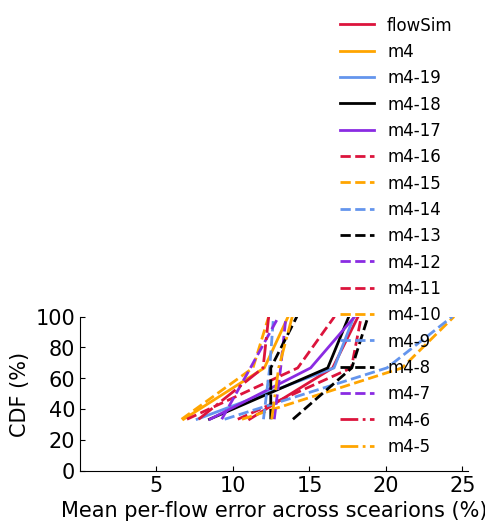

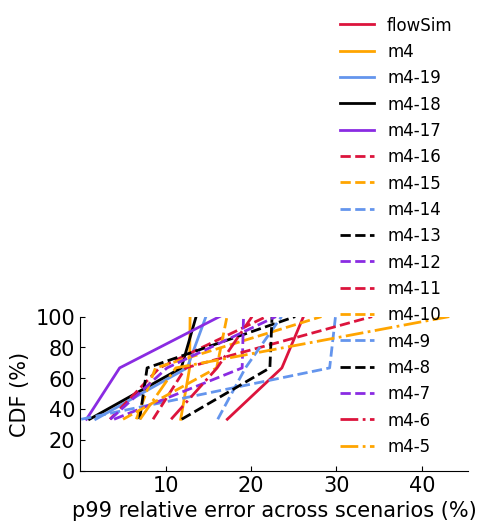

In [13]:
n_scenario=3
empirical_str = "eval_test_large"
legend_list=['flowSim','m4','m4-19','m4-18','m4-17','m4-16','m4-15','m4-14','m4-13','m4-12','m4-11','m4-10','m4-9','m4-8','m4-7','m4-6','m4-5']
model_instance_list=['flowsim','m4_10','final_19','final_18','final_17','final_16','final_15','final_14','final_13','final_12','final_11','final_10','final_9','final_8','final_7','final_6','final_5']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc']
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

# print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Mean per-flow error across scearions (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=0,
)

plot_cdf(
    error_list_p99,
    None,
    legend_list,
    x_label="p99 relative error across scenarios (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=1,
)

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3, 0.4,0.5, 0.6, 0.7, 0.8]
labels = ['0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bins = [10,12,14,16,18,20]
labels = ['10-12', '12-14', '14-16', '16-18', '18-20']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [10000,12000,14000,16000,18000,20000]
labels = ['10000-12000', '12000-14000', '14000-16000', '16000-18000', '18000-20000']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)


# Function to plot box plots for each configuration type
# def plot_box_by_config(error_list, config_list, legend_list, config_index, config_name):
#     unique_configs = np.unique(config_list[:, config_index])
#     n_methods = len(legend_list)
    
#     # Prepare data for each unique configuration type
#     data_to_plot = {config_value: [[] for _ in range(n_methods)] for config_value in unique_configs}
#     for i, config_value in enumerate(config_list[:, config_index]):
#         for j in range(n_methods):
#             data_to_plot[config_value][j].append(error_list[i, j])
    
#     # Plot the data
#     plt.figure(figsize=(10, 6))
#     x_positions = np.arange(len(unique_configs))
#     box_width = 0.8 / n_methods  # Adjust width based on number of methods
#     colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
#     handles = []
    
#     for j, method_label in enumerate(legend_list):
#         method_data = [data_to_plot[config_value][j] for config_value in unique_configs]
#         positions = x_positions - 0.4 + (j + 0.5) * box_width  # Center the boxes
#         bp = plt.boxplot(method_data, positions=positions, widths=box_width,
#                          patch_artist=True, 
#                          boxprops=dict(facecolor=colors[j % len(colors)], color=colors[j % len(colors)]),
#                          medianprops=dict(color="black"))
#         handles.append(bp["boxes"][0])

#     plt.title(f"Relative Error by {config_name} Configuration")
#     plt.xlabel(config_name)
#     plt.ylabel("Relative Error (%)")
#     plt.xticks(x_positions, unique_configs, rotation=45)
#     plt.legend(handles, legend_list)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# Generate plots for each configuration attribute
config_attributes = ["Spatial", "Size Distribution", "Cluster", "Max Load", "Lognorm Sigma", "CC", "BFSZ", "FWIN"]
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list.T, config_list, legend_list, config_index=i, config_name=config_name)

flowsim_large0-sldn: (85584,)
p99 slowdown: 2.70716249702616, 3.3371159918619004
m4_10_large0-sldn: (85584,)
p99 slowdown: 3.584040670394889, 3.3371159918619004
mean error:[19.796066156243874, 8.041182822247826]
p99 error: [18.87718306  7.3993436 ]


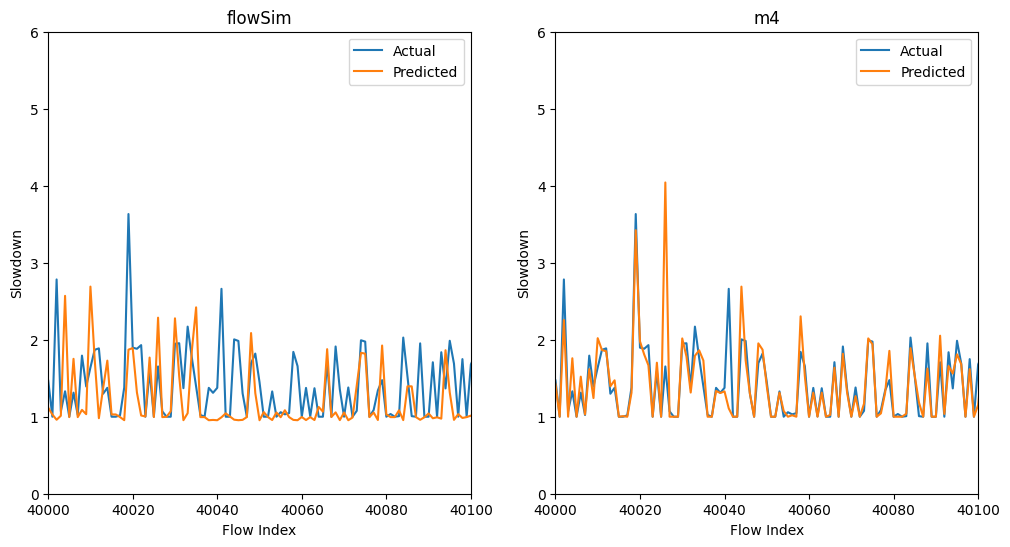

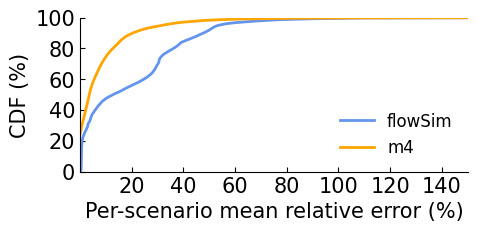

In [ ]:
empirical_str = ""
scenario_str="_large0"
# scenario_str=""
# legend_list=['flowSim','m4-flowsim-input','m4-final']
# model_instance_list=[f'flowsim{scenario_str}', f'topo_512_flowsim_input_dropout_19{scenario_str}',f'topo_reprod_19{scenario_str}']
# legend_list=['flowSim','m4','m4-data']
# model_instance_list=[f'flowsim{scenario_str}', f'topo_featrate_7{scenario_str}', f'topo_remainsize_large_data_7{scenario_str}']
# legend_list=['flowSim','m4-pre','m4']
# model_instance_list=[f'flowsim{scenario_str}', f'topo_featrate_7{scenario_str}',f'final_7{scenario_str}']
# legend_list=['flowSim','m4','m4-param']
# model_instance_list=[f'flowsim{scenario_str}',f'final_7{scenario_str}',f'final_param_6{scenario_str}']
# legend_list=['flowSim','m4','m4-GNN','m4-GNN-queue']
# model_instance_list=[f'flowsim{scenario_str}',f'final_param_6{scenario_str}',f"final_gnn_layer4_4{scenario_str}",f'm4_15{scenario_str}']
# legend_list=['flowSim','m4','m4-Queue','m4-noflowsim']
# model_instance_list=[f'flowsim{scenario_str}',f'final_param_6{scenario_str}',f'm4_15{scenario_str}',f"m4_noflowsim_9{scenario_str}"]
# legend_list=['flowSim','m4','m4-Queue','m4-16','m4-10']
# model_instance_list=[f'flowsim{scenario_str}',f'bm4_14{scenario_str}',f'bm4_15{scenario_str}',f"m4_16{scenario_str}",f"m4_10{scenario_str}"]
legend_list=['flowSim','m4']
model_instance_list=[f'flowsim{scenario_str}',f"m4_10{scenario_str}"]
                     
error_list=[]
error_list_p99=[]
sldn_list=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[:, :, 0].squeeze()
    actual_sldns = sldn[:,:, 1].squeeze()
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_list.append([actual_sldns,predicted_sldns])
    error_list.append(relative_error_sldn)
    
    sldn_p99_est=np.percentile(predicted_sldns,99)
    sldn_p99_act=np.percentile(actual_sldns,99)
    print(f"p99 slowdown: {sldn_p99_est}, {sldn_p99_act}")
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)
sldn_list=np.array(sldn_list)
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"p99 error: {error_list_p99}")
      
# Plotting
fig, axes = plt.subplots(1, len(model_instance_list), figsize=(12, 6))

# Plot each method in a subfigure
for i, (actual, predicted) in enumerate(sldn_list):
    axes[i].plot(actual, label="Actual")
    axes[i].plot(predicted, label="Predicted")
    axes[i].set_title(legend_list[i])
    axes[i].set_xlabel("Flow Index")
    axes[i].set_ylabel("Slowdown")
    axes[i].legend()
    axes[i].set_xlim(40000, 40100)
    axes[i].set_ylim(0, 6)
plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Per-scenario mean relative error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=200,
    xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
)

ns-3: 94
m4: 94
ns-3: 2907.9704255319148, m4: 241.19317416941865, flowsim: 56.40186381340027


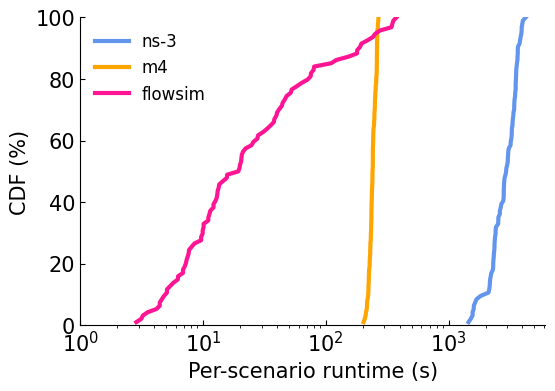

In [ ]:
import re
n_scenario=100
empirical_str='eval_test_8k'
data_root="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8"
legend_list=['ns-3', 'm4', 'flowsim']
res=[]

time_ns3=[]
'''
for i in range(n_scenario):
    if os.path.exists(f'{data_root}/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        time_file=f'{data_root}/{empirical_str}/{i}/ns3/elapsed.txt'
        with open(time_file, "r") as file:
            number = float(file.read().strip())
            time_ns3.append(number)
res.append(time_ns3)     
print(f"ns-3: {len(time_ns3)}")  
'''

with open(f'{data_root}/{empirical_str}/ns3_times.txt') as f:
    time_ns3 = [float(txt.replace("\n", "")) for txt in f.readlines()]

print(f"ns-3: {len(time_ns3)}")  
res.append(time_ns3)

def read_log_file(file_path):
    try:
        with open(file_path, 'r') as file:
            log_text = file.read()
        return log_text
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None

def extract_scenario_times(log_text):
    # Regex patterns for time elapsed and workload scenario
    time_pattern = r"Time elapsed:\s([\d.]+)"

    # Extract times and workload IDs
    elapsed_times = re.findall(time_pattern, log_text)

    # Create a dictionary mapping scenario ID to time elapsed
    scenario_times = []
    for workload_idx, time in enumerate(elapsed_times):
        time=float(time)
        scenario_times.append(float(time))
    
    return scenario_times

log_text = read_log_file(f'{empirical_str}.log')
time_m4 = extract_scenario_times(log_text)
res.append(time_m4)
print(f"m4: {len(time_m4)}")

with open(f'{data_root}/{empirical_str}/flowsim_times.txt') as f:
    flowsim_times = [float(txt.replace("\n", "")) for txt in f.readlines()]

res.append(flowsim_times)

res=np.array(res)
print(f"ns-3: {np.mean(res[0])}, m4: {np.mean(res[1])}, flowsim: {np.mean(res[2])}")

fig_index=0
plot_cdf(
    res,
    None,
    legend_list,
    x_label="Per-scenario runtime (s)",
    log_switch=True,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=1,
    fontsize=15,
    legend_font=12,
    loc=2,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_index
)
fig_index=1